## Exploration of the parameters for a good ensemble model

`grant_tagger.py` was run with all combinations of the following vectorizers and classifiers:

Vectorizer: 
1. Count
2. TF-IDF
3. BERT
4. SciBERT

Classifier: 
1. Naïve Bayes
2. SVM
3. Logistic regression

This outputted in **12 trained models**. We also have the predictions of each model on a test set.

Test each combination of models and the number that need to agree to find the best parameters for an ensemble model. This information can be put into a config file for use in `ensemble_grant_tagger.py` to make future predictions.



In [108]:
import json
import itertools
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

## Load data

In [2]:
date_model_test ='210402'

In [138]:
# Test performance of each model
if int(date_model_test) < 210331:
    with open(f'../data/processed/model_test_results/models_summary_{date_model_test}.jsonl') as f:
        model_results = json.load(f)
        
    # The test predictions for each model
    model_predictions = pd.read_csv(f'../data/processed/model_test_results/model_test_results_{date_model_test}.csv')

    # Merge the model test predictions with the actual test values
    test_data = pd.read_csv(f'../data/processed/model_test_results/test_data_{date_model_test}.csv')
    model_predictions = pd.merge( 
        model_predictions,
        test_data[['Internal ID', 'Relevance code']],
        how = 'left',
        on = ['Internal ID']
        )
else:
    # The test truth and predictions for each model
    training_info_file = os.path.join('..', 'models', date_model_test, 'training_information.json')
    all_models_info = {}
    all_models_probs = {}
    with open(training_info_file, 'r') as file:
        for line in file:
            model_data = json.loads(line)
            model_name = list(model_data.keys())[0]
            test_results = pd.DataFrame([m for m in model_data[model_name].values() if m['Test/train']=='Test'])
            all_models_info[model_name] = test_results['Prediction']
            all_models_probs[model_name] = test_results['Prediction probability']

    model_predictions = pd.DataFrame(all_models_info)
    model_names = model_predictions.columns
    # The ground truth will be the same for every model,
    # so just save out for the last line
    model_predictions['Relevance code'] = test_results['Truth']
    model_predictions['Internal ID'] = [grant_id for grant_id, m in model_data[model_name].items() if m['Test/train']=='Test']

    not_used_info = [(grant_id, m['Truth']) for grant_id, m in model_data[model_name].items() if m['Test/train']=='Not used']
    
    # The probabilities for each model prediction (will map to rows of model_predictions)
    model_predictions_probs = pd.DataFrame(all_models_probs)
    
    model_results = {}
    for model_name in model_names:
        y_true = model_predictions['Relevance code']
        y_pred = model_predictions[model_name]
        model_results[model_name] = {
                    'f1': f1_score(y_true, y_pred),
                    'precision_score': precision_score(y_true, y_pred),
                    'recall_score': recall_score(y_true, y_pred)
                    }

model_results = pd.DataFrame(model_results).T
model_results['model_name'] = ['_'.join(m.split('_')[0:-1]) for m in model_results.index]
model_results['Type'] = ['Original model']*len(model_results)

In [4]:
model_results

,f1,precision_score,recall_score,model_name,Type
count_naive_bayes_210402,0.827957,0.726415,0.9625,count_naive_bayes,Original model
count_SVM_210402,0.820513,0.842105,0.8000,count_SVM,Original model
count_log_reg_210402,0.825000,0.825000,0.8250,count_log_reg,Original model
tfidf_naive_bayes_210402,0.810526,0.700000,0.9625,tfidf_naive_bayes,Original model
tfidf_SVM_210402,0.829268,0.809524,0.8500,tfidf_SVM,Original model
tfidf_log_reg_210402,0.823529,0.777778,0.8750,tfidf_log_reg,Original model
bert_naive_bayes_210402,0.764398,0.657658,0.9125,bert_naive_bayes,Original model
bert_SVM_210402,0.848485,0.823529,0.8750,bert_SVM,Original model
bert_log_reg_210402,0.894410,0.888889,0.9000,bert_log_reg,Original model
scibert_naive_bayes_210402,0.808989,0.734694,0.9000,scibert_naive_bayes,Original model


In [5]:
model_predictions.head(2)

,count_naive_bayes_210402,count_SVM_210402,count_log_reg_210402,tfidf_naive_bayes_210402,tfidf_SVM_210402,tfidf_log_reg_210402,bert_naive_bayes_210402,bert_SVM_210402,bert_log_reg_210402,scibert_naive_bayes_210402,scibert_SVM_210402,scibert_log_reg_210402,Relevance code,Internal ID
0,1,1,1,1,1,1,1,1,1,1,1,1,1,103709/Z/14/A
1,1,0,0,1,0,0,0,0,1,0,0,1,1,202571/Z/16/Z


## Visualise the precision/recall for each model

In [6]:
min_precision = model_results['precision_score'].min()
max_precision = model_results['precision_score'].max()
print((min_precision, max_precision))

min_recall = model_results['recall_score'].min()
max_recall = model_results['recall_score'].max()
print((min_recall, max_recall))

min_both = min(min_precision, min_recall)-0.1
max_both = min(max_precision, max_recall)+0.1

(0.6576576576576577, 0.8888888888888888)
(0.8, 0.9625)


In [7]:
def pick_col_shape(model_name):
    for vec_name in colour_map.keys():
        if vec_name in model_name:
            col = colour_map[vec_name]
            break
        else:
            # bert
            col = 'blue'
    for class_name in shape_map.keys():
        if class_name in model_name:
            shape = shape_map[class_name]
            
    return col, shape

In [8]:
colour_map = {'scibert': 'green', 'count': 'red', 'tfidf': 'orange'}
shape_map = {'log_reg': 'v', 'SVM': 'x', 'naive_bayes': '.'}

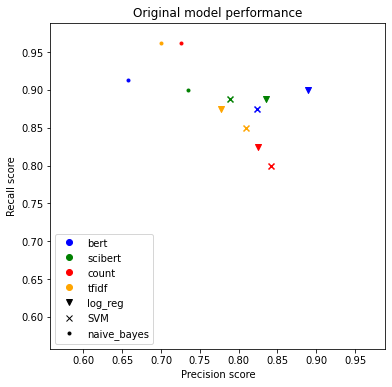

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set(xlim=(min_both,max_both),
    ylim=(min_both,max_both))
for k, v in model_results.iterrows():
    col, shape = pick_col_shape(v['model_name'])
    ax.scatter(
    v['precision_score'],
    v['recall_score'],
    c = col,
    marker=shape,
    label='point')

ax.set(xlabel='Precision score', ylabel='Recall score', 
       title='Original model performance');

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker='o', color='blue', linewidth=0)]
for vec_name, col in colour_map.items():
    custom_lines.append(Line2D([0], [0], marker='o', color=col, linewidth=0))
for class_name, shape in shape_map.items():
    custom_lines.append(Line2D([0], [0], marker=shape, color='k', linewidth=0))
     
ax.legend(custom_lines, ['bert']+list(colour_map.keys())+list(shape_map.keys()), loc='lower left')

## Prediction probabilities

In [10]:
tech_probs = []
not_tech_probs = []
for row_i, row in model_predictions_probs.iterrows():
    for col_name, pred_prob in enumerate(row):
        if model_predictions.iloc[row_i][col_name]==1:
            tech_probs.append(pred_prob)
        else:
            not_tech_probs.append(pred_prob)

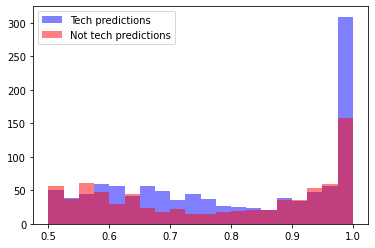

In [11]:
plt.hist(tech_probs, bins=20, alpha = 0.5, color='blue', label='Tech predictions');
plt.hist(not_tech_probs, bins=20, alpha = 0.5, color='red', label='Not tech predictions');
plt.legend();

## Test ensemble models using all combinations of models

In [12]:
# Get every combination of models
models_list = model_results.index.tolist()
all_combinations = []
for r in range(1, len(models_list) + 1):
    combinations_object = itertools.combinations(models_list, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list
len(all_combinations)

4095

In [13]:
# Find the test performance for each model combition and number of models that need to agree
labels = model_predictions['Relevance code']

average_type = 'binary'
all_combos_scores = []
for i, model_combination in enumerate(all_combinations):
    if i%1000==0:
        print(i)
    for prob_thresh in np.linspace(0.5,0.95,20):
        # If a tech prediction is >= probability threshold then keep as tech, 
        # otherwise set to 0
        pred_threshold_mask = model_predictions_probs[list(model_combination)] >= prob_thresh
        model_combos_predictions = model_predictions[list(model_combination)]*pred_threshold_mask
#         model_combos_predictions = model_predictions[list(model_combination)]
        # How many of the models agree on tech grant prediction?
        prediction_sums = model_combos_predictions.sum(axis=1)
#         if (model_combos_predictions==1).sum().sum() != 0:
#             # Only include if there is at least one prediction is for a tech grant
        for num_agree in range(1, len(model_combination)+1):
            # Calculate test metrics
            y_pred = [1 if pred_sum >= num_agree else 0 for pred_sum in prediction_sums]
            all_combos_scores.append({
                'Type': 'Ensemble model',
                'model_name': model_combination,
                'num_models': len(model_combination),
                'probability threshold': prob_thresh,
                'num_agree': num_agree,
                'f1': f1_score(labels, y_pred, average=average_type),
                'precision_score': precision_score(labels, y_pred, zero_division=0, average=average_type),
                'recall_score': recall_score(labels, y_pred, zero_division=0, average=average_type)
                })
all_combos_scores_df = pd.DataFrame(all_combos_scores)

0
1000
2000
3000
4000


In [14]:
# How many BERT models are there in the ensemble
all_combos_scores_df['num_bert'] = all_combos_scores_df['model_name'].apply(lambda x: sum(['bert' in model for model in list(x)]))

In [15]:
len(all_combos_scores_df)

491520

## Save out
Not all data needs to be saved out as there are a lot of repeats.
Less models and less models involving BERT is good for speed - so order by these and remove duplicates.

In [16]:
all_combos_scores_df_small = all_combos_scores_df.copy()
all_combos_scores_df_small.sort_values(by = ['num_models', 'num_bert'], inplace=True)
all_combos_scores_df_small.drop_duplicates(subset = ['precision_score', 'recall_score'], inplace=True)
len(all_combos_scores_df_small)

534

In [17]:
all_combos_scores_df_small.to_csv(os.path.join('..', 'models', date_model_test, 'ensemble_information.json'))

## Plot all points

In [18]:
min_all_ensemble = all_combos_scores_df[['precision_score', 'recall_score']].min().min() - 0.05
max_all_ensemble = all_combos_scores_df[['precision_score', 'recall_score']].max().max() + 0.05

In [19]:
all_combos_scores_df['Random precision noise'] = np.random.uniform(-0.01, 0.01, len(all_combos_scores_df))
all_combos_scores_df['Random recall noise'] = np.random.uniform(-0.01, 0.01, len(all_combos_scores_df))
all_combos_scores_df['precision_score_jitter'] = all_combos_scores_df[['precision_score', 'Random precision noise']].sum(axis=1)
all_combos_scores_df['recall_score_jitter'] = all_combos_scores_df[['recall_score', 'Random recall noise']].sum(axis=1)

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


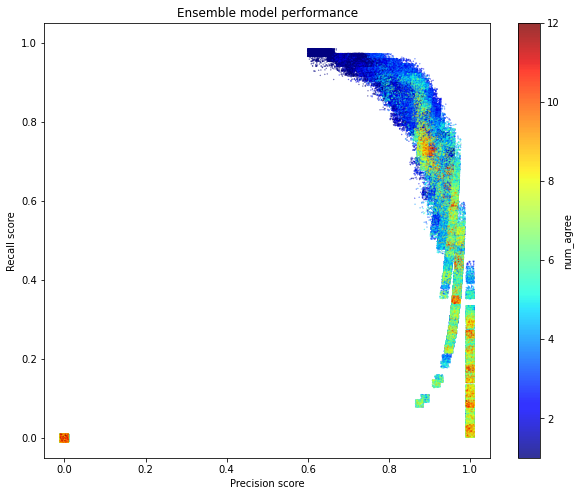

In [20]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='num_agree',
    alpha=0.8,
    s=0.1,
    colormap="jet",
    sharex=False,
    xlim=axis_lims,
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

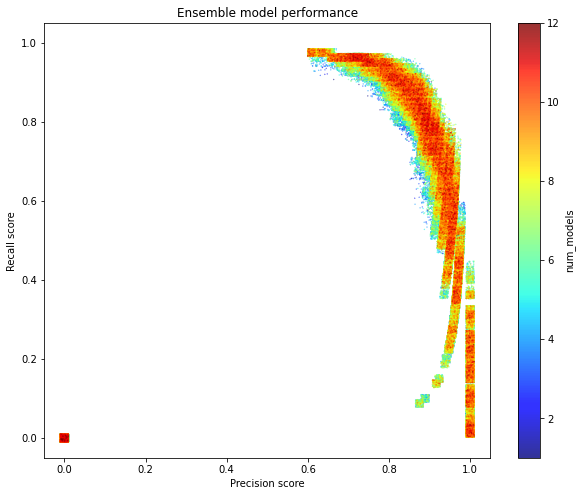

In [21]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='num_models',
    colormap="jet",
    alpha=0.8,
    s=0.1,
    sharex=False,
    xlim=axis_lims,
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

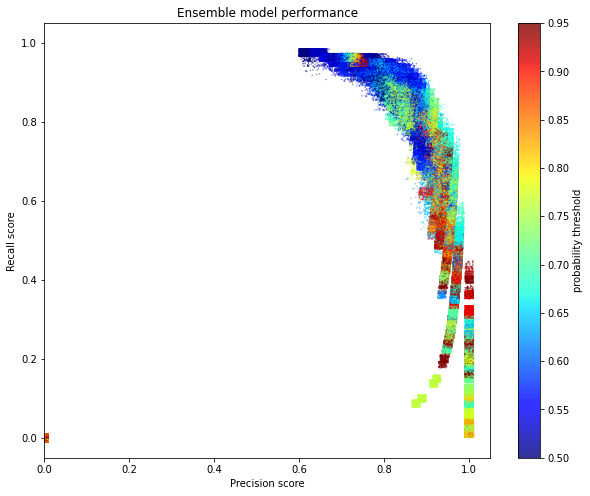

In [22]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='probability threshold',
    colormap="jet",
    alpha=0.8,
    s=0.1,
    sharex=False,
    xlim=(0,1.05),
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

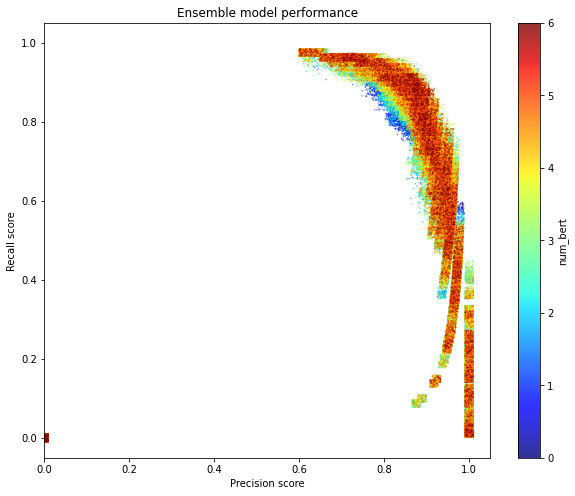

In [23]:
axis_lims = (min_all_ensemble, max_all_ensemble)

all_combos_scores_df.plot.scatter(
    'precision_score_jitter',
    'recall_score_jitter',
    figsize=(10,8),
    c='num_bert',
    colormap="jet",
    alpha=0.8,
    s=0.1,
    sharex=False,
    xlim=(0,1.05),
    ylim=axis_lims,
    title='Ensemble model performance',
    xlabel='Precision score',
    ylabel='Recall score'
);

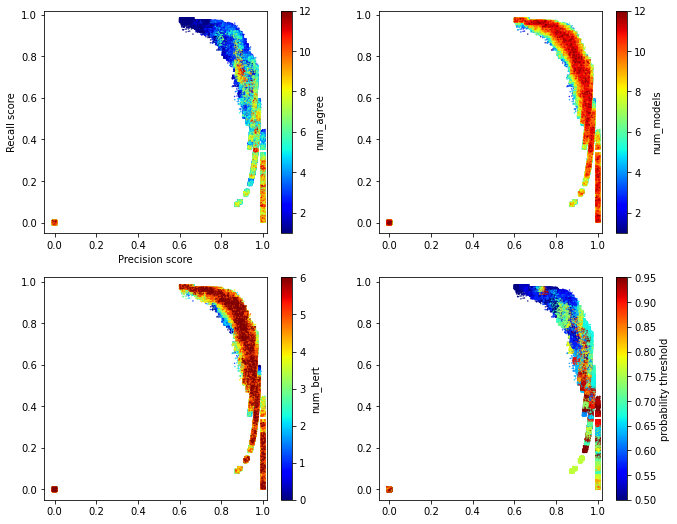

In [24]:
x_axis_lims = (-0.05,1.02)
y_axis_lims = (-0.05,1.02)
point_size = 0.2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,9));

all_combos_scores_df.plot.scatter(
    ax=axes[0,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_agree', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='Precision score', ylabel='Recall score')
all_combos_scores_df.plot.scatter(
    ax=axes[0,1], x='precision_score_jitter', y='recall_score_jitter',
    c='num_models', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df.plot.scatter(
    ax=axes[1,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_bert', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df.plot.scatter(
    ax=axes[1,1], x='precision_score_jitter', y='recall_score_jitter',
    c='probability threshold', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims,
    s=point_size, xlabel='', ylabel='');

## All together, just for high scores

In [25]:
all_combos_scores_df_high = all_combos_scores_df.copy().loc[
    (
        (all_combos_scores_df['precision_score'] >= 0.85) & 
        (all_combos_scores_df['recall_score'] >= 0.8)
    )
]
len(all_combos_scores_df_high)

74595

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


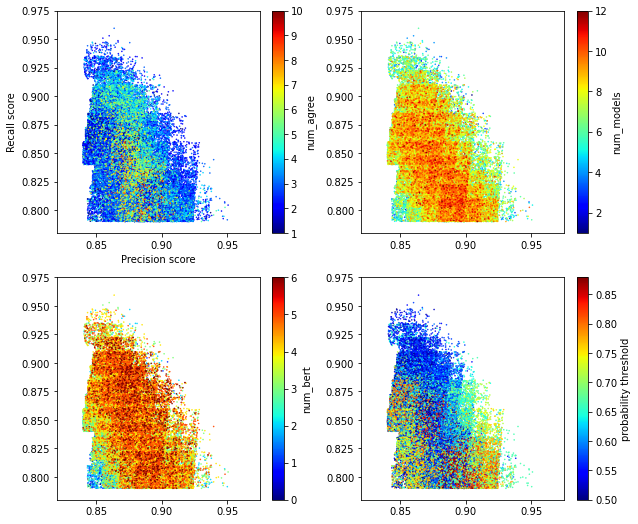

In [26]:
x_axis_lims = (0.82,0.975)
y_axis_lims = (0.78,0.975)
point_size = 0.3
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,9));

all_combos_scores_df_high.plot.scatter(
    ax=axes[0,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_agree', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='Precision score', ylabel='Recall score')
all_combos_scores_df_high.plot.scatter(
    ax=axes[0,1], x='precision_score_jitter', y='recall_score_jitter',
    c='num_models', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df_high.plot.scatter(
    ax=axes[1,0], x='precision_score_jitter', y='recall_score_jitter',
    c='num_bert', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims, s=point_size,
    xlabel='', ylabel='')
all_combos_scores_df_high.plot.scatter(
    ax=axes[1,1], x='precision_score_jitter', y='recall_score_jitter',
    c='probability threshold', colormap="jet", xlim=x_axis_lims, ylim=y_axis_lims,
    s=point_size, xlabel='', ylabel='');

### Plot ensemble results with original single model results

In [27]:
combined_results = pd.concat([model_results, all_combos_scores_df])

In [28]:
# We want to colour original models by vectoriser used, so set up a colour column for this
vects = ['scibert', 'count', 'tfidf']
model_vect = []
for _, row in combined_results.iterrows():
    if row['Type']== 'Ensemble model':
        model_vect.append('ensemble')
    else:
        which_vect = [i for i in vects if i in row['model_name']]
        if len(which_vect)==0:
            model_vect.append('bert')
        else:
            model_vect.append(which_vect[0])
    
combined_results['Vectorizer type'] = model_vect
colour_map = {'scibert': 'green', 'bert': 'blue', 'count': 'red', 'tfidf': 'orange', 'ensemble': 'black'}
combined_results['Vectorizer type colour'] = [colour_map[c] for c in combined_results['Vectorizer type']]

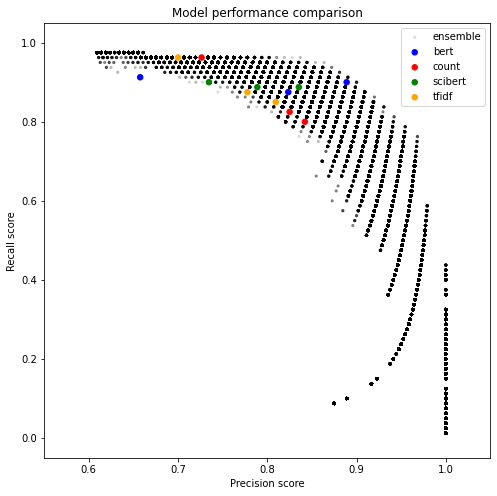

In [29]:
vectorizer_groups = combined_results.groupby('Vectorizer type')

# Plot the ensemble results first since there are so many
group_names = list(vectorizer_groups.groups.keys())
group_names.remove('ensemble')
group_order = ['ensemble'] + group_names

fig, ax = plt.subplots(1, figsize=(8,8))
ax.set(xlim=(0.55, max_all_ensemble),
    ylim=(min_all_ensemble, max_all_ensemble))
for label in group_order:
    if label == 'ensemble':
        alpha = 0.1
        size = 5
    else:
        alpha = 1
        size = 30
    group = vectorizer_groups.get_group(label)
    ax.scatter(
        group['precision_score'],
        group['recall_score'],
        c=group['Vectorizer type colour'],
        label=label,
        alpha=alpha,
        s=size
    )

ax.set(xlabel='Precision score', ylabel='Recall score', 
       title='Model performance comparison')
ax.legend()
plt.show()

## The highest performing ensemble models
- high precision
- high recall
- doesn't take too long - not too many BERT or SciBERT vectorizers in the ensemble

In [57]:
precision_threshold = 0.9
recall_threshold = 0.9
min_bert = 2

In [58]:
best_results = all_combos_scores_df.loc[
    (
        (all_combos_scores_df['precision_score'] >= precision_threshold) & 
        (all_combos_scores_df['recall_score'] >= recall_threshold) &
        (all_combos_scores_df['num_bert'] <= min_bert)
    )
]
print(len(best_results))
best_results

4


,Type,model_name,num_models,probability threshold,num_agree,f1,precision_score,recall_score,num_bert,Random precision noise,Random recall noise,precision_score_jitter,recall_score_jitter
162,Ensemble model,"(bert_log_reg_210402,)",1,0.547368,1,0.9,0.9,0.9,1,0.004589,0.000965,0.904589,0.900965
525,Ensemble model,"(count_naive_bayes_210402, bert_log_reg_210402)",2,0.547368,2,0.9,0.9,0.9,1,0.001043,-0.006967,0.901043,0.893033
24029,Ensemble model,"(count_naive_bayes_210402, tfidf_naive_bayes_2...",4,0.665789,2,0.9,0.9,0.9,2,0.000055,0.001899,0.900055,0.901899
78716,Ensemble model,"(count_naive_bayes_210402, tfidf_naive_bayes_2...",5,0.665789,2,0.9,0.9,0.9,2,-0.002988,0.005900,0.897012,0.905900


In [48]:
best_results['model_name'].tolist()

[('bert_log_reg_210402',),
 ('count_naive_bayes_210402', 'bert_log_reg_210402'),
 ('count_naive_bayes_210402',
  'tfidf_naive_bayes_210402',
  'bert_SVM_210402',
  'bert_log_reg_210402'),
 ('count_naive_bayes_210402',
  'tfidf_naive_bayes_210402',
  'tfidf_log_reg_210402',
  'bert_SVM_210402',
  'bert_log_reg_210402')]

### How well do the best models translate to EPMC and RF data
This takes a moderate amount of time to run so only calculate these scores on the best models.
i.e. for the models that perform well on the test data - how well do they translate to predicting on EPMC and RF data?

In [ ]:
cd ..

In [88]:
from nutrition_labels.grant_tagger_evaluation import merge_eval_grants
from nutrition_labels.grant_tagger import GrantTagger
from nutrition_labels.ensemble_grant_tagger import EnsembleGrantTagger

In [150]:
epmc_evaluation_data = pd.read_csv('data/processed/training_data/210329epmc/training_data.csv')
rf_evaluation_data = pd.read_csv('data/processed/training_data/210329rf/training_data.csv')

grants_data = pd.read_csv('data/processed/fortytwo/tech_210308_training_data_fortytwo_info.csv')

prediction_cols = ['Title','Synopsis']
grants_text_data_file_id = 'Reference'

epmc_evaluation_data = merge_eval_grants(
        epmc_evaluation_data,
        grants_data,
        prediction_cols,
        grants_text_data_file_id
        )
rf_evaluation_data = merge_eval_grants(
    rf_evaluation_data,
    grants_data,
    prediction_cols,
    grants_text_data_file_id
    )

unused_evaluation_data = merge_eval_grants(
    pd.DataFrame(not_used_info, columns=['Internal ID', 'Relevance code']),
    grants_data,
    prediction_cols,
    grants_text_data_file_id
    )

In [156]:
from collections import Counter
print(Counter(epmc_evaluation_data['Relevance code']))
print(Counter(rf_evaluation_data['Relevance code']))
print(Counter(unused_evaluation_data['Relevance code']))

Counter({1: 148})
Counter({1: 70})
Counter({0: 175})


In [125]:
y_actual_epmc = epmc_evaluation_data['Relevance code'].tolist()
y_actual_rf = rf_evaluation_data['Relevance code'].tolist()
y_actual_unused = unused_evaluation_data['Relevance code'].tolist()

# Use grant tagger to process texts
grant_tagger = GrantTagger(prediction_cols=prediction_cols)
grant_data_epmc = grant_tagger.process_grant_text(epmc_evaluation_data)
grant_data_rf = grant_tagger.process_grant_text(rf_evaluation_data)
grant_data_unused = grant_tagger.process_grant_text(unused_evaluation_data)
  
combos_translation_scores = []
average_type = 'binary'
for i, row in best_results.iterrows():
    model_combination = ['models/210402/'+m for m in row['model_name']]
    threshold = row['probability threshold']
    num_agree = row['num_agree']
    tech_grant_model = EnsembleGrantTagger(
        model_dirs=model_combination,
        num_agree=num_agree,
        grant_text_cols=prediction_cols,
        grant_id_col="Reference",
        threshold=threshold
        )

    predictions_epmc = tech_grant_model.predict(grant_data_epmc['Grant texts'].tolist())
    predictions_rf = tech_grant_model.predict(grant_data_rf['Grant texts'].tolist())
    predictions_unused = tech_grant_model.predict(grant_data_unused['Grant texts'].tolist())
    
    combos_translation_scores.append({
                'model_name': row['model_name'],
                'probability threshold': threshold,
                'num_agree': num_agree,
                'EPMC accuracy': accuracy_score(y_actual_epmc, predictions_epmc),
                'RF accuracy': accuracy_score(y_actual_rf, predictions_rf),
                'Unused accuracy': accuracy_score(y_actual_unused, predictions_unused)
                })
    



  0%|          | 0/148 [00:00<?, ?it/s]

  1%|          | 1/148 [00:00<02:03,  1.19it/s]

  2%|▏         | 3/148 [00:01<01:11,  2.03it/s]

  3%|▎         | 4/148 [00:03<02:05,  1.15it/s]

  3%|▎         | 5/148 [00:04<02:41,  1.13s/it]

  4%|▍         | 6/148 [00:05<02:15,  1.05it/s]

  5%|▍         | 7/148 [00:06<02:21,  1.00s/it]

  5%|▌         | 8/148 [00:07<02:23,  1.02s/it]

  6%|▌         | 9/148 [00:08<02:09,  1.07it/s]

  7%|▋         | 10/148 [00:09<02:02,  1.12it/s]

  7%|▋         | 11/148 [00:09<02:01,  1.13it/s]

  8%|▊         | 12/148 [00:10<02:00,  1.13it/s]

  9%|▉         | 13/148 [00:12<02:26,  1.08s/it]

  9%|▉         | 14/148 [00:15<03:38,  1.63s/it]

 10%|█         | 15/148 [00:16<03:10,  1.43s/it]

 11%|█         | 16/148 [00:17<02:42,  1.23s/it]

 11%|█▏        | 17/148 [00:17<02:25,  1.11s/it]

 12%|█▏        | 18/148 [00:18<02:08,  1.01it/s]

 13%|█▎        | 19/148 [00:19<01:58,  1.09it/s]

 14%|█▎        | 20/148 [00:20<02:04,  1.03it/s]

 14%|█▍        

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:00<00:49,  1.40it/s]

  3%|▎         | 2/70 [00:01<00:49,  1.38it/s]

  4%|▍         | 3/70 [00:02<00:53,  1.25it/s]

  6%|▌         | 4/70 [00:03<00:49,  1.34it/s]

  7%|▋         | 5/70 [00:03<00:49,  1.31it/s]

  9%|▊         | 6/70 [00:04<00:45,  1.39it/s]

 10%|█         | 7/70 [00:05<00:46,  1.35it/s]

 11%|█▏        | 8/70 [00:05<00:45,  1.38it/s]

 13%|█▎        | 9/70 [00:06<00:43,  1.40it/s]

 14%|█▍        | 10/70 [00:07<00:43,  1.38it/s]

 16%|█▌        | 11/70 [00:08<00:44,  1.34it/s]

 17%|█▋        | 12/70 [00:08<00:32,  1.80it/s]

 19%|█▊        | 13/70 [00:08<00:23,  2.38it/s]

 20%|██        | 14/70 [00:09<00:29,  1.89it/s]

 21%|██▏       | 15/70 [00:10<00:36,  1.52it/s]

 23%|██▎       | 16/70 [00:10<00:38,  1.41it/s]

 24%|██▍       | 17/70 [00:11<00:38,  1.38it/s]

 26%|██▌       | 18/70 [00:12<00:38,  1.34it/s]

 27%|██▋       | 19/70 [00:13<00:37,  1.36it/s]

 29%|██▊       | 20/70 [00:13<00:35,  

 54%|█████▍    | 80/148 [00:55<01:03,  1.08it/s]

 55%|█████▍    | 81/148 [00:56<00:58,  1.15it/s]

 55%|█████▌    | 82/148 [00:57<00:56,  1.18it/s]

 56%|█████▌    | 83/148 [00:57<00:52,  1.24it/s]

 57%|█████▋    | 84/148 [00:58<00:47,  1.34it/s]

 57%|█████▋    | 85/148 [00:59<00:48,  1.31it/s]

 58%|█████▊    | 86/148 [00:59<00:44,  1.38it/s]

 59%|█████▉    | 87/148 [01:00<00:45,  1.35it/s]

 59%|█████▉    | 88/148 [01:01<00:47,  1.25it/s]

 60%|██████    | 89/148 [01:02<00:46,  1.26it/s]

 61%|██████    | 90/148 [01:03<00:46,  1.26it/s]

 61%|██████▏   | 91/148 [01:03<00:46,  1.23it/s]

 62%|██████▏   | 92/148 [01:05<00:49,  1.12it/s]

 63%|██████▎   | 93/148 [01:06<00:54,  1.01it/s]

 64%|██████▎   | 94/148 [01:07<00:49,  1.10it/s]

 64%|██████▍   | 95/148 [01:07<00:48,  1.10it/s]

 65%|██████▍   | 96/148 [01:08<00:47,  1.10it/s]

 66%|██████▌   | 97/148 [01:09<00:43,  1.17it/s]

 66%|██████▌   | 98/148 [01:10<00:40,  1.22it/s]

 67%|██████▋   | 99/148 [01:11<00:39,  1.24it/s]



  5%|▌         | 8/148 [00:11<02:57,  1.26s/it]

  6%|▌         | 9/148 [00:12<02:51,  1.23s/it]

  7%|▋         | 10/148 [00:13<02:56,  1.28s/it]

  7%|▋         | 11/148 [00:15<02:59,  1.31s/it]

  8%|▊         | 12/148 [00:15<02:40,  1.18s/it]

  9%|▉         | 13/148 [00:17<02:36,  1.16s/it]

  9%|▉         | 14/148 [00:18<02:35,  1.16s/it]

 10%|█         | 15/148 [00:19<02:30,  1.13s/it]

 11%|█         | 16/148 [00:20<02:29,  1.13s/it]

 11%|█▏        | 17/148 [00:21<02:32,  1.17s/it]

 12%|█▏        | 18/148 [00:22<02:23,  1.10s/it]

 13%|█▎        | 19/148 [00:23<02:12,  1.03s/it]

 14%|█▎        | 20/148 [00:24<02:12,  1.03s/it]

 14%|█▍        | 21/148 [00:25<02:15,  1.07s/it]

 15%|█▍        | 22/148 [00:26<02:07,  1.01s/it]

 16%|█▌        | 23/148 [00:27<01:58,  1.05it/s]

 16%|█▌        | 24/148 [00:28<01:56,  1.07it/s]

 17%|█▋        | 25/148 [00:29<01:57,  1.04it/s]

 18%|█▊        | 26/148 [00:30<01:53,  1.08it/s]

 18%|█▊        | 27/148 [00:31<01:50,  1.09it/s]

 1

  5%|▍         | 7/148 [00:05<01:59,  1.18it/s]

  5%|▌         | 8/148 [00:06<02:05,  1.11it/s]

  6%|▌         | 9/148 [00:07<02:03,  1.13it/s]

  7%|▋         | 10/148 [00:08<02:04,  1.11it/s]

  7%|▋         | 11/148 [00:09<02:06,  1.08it/s]

  8%|▊         | 12/148 [00:09<01:56,  1.17it/s]

  9%|▉         | 13/148 [00:10<01:51,  1.21it/s]

  9%|▉         | 14/148 [00:11<01:46,  1.26it/s]

 10%|█         | 15/148 [00:12<01:45,  1.26it/s]

 11%|█         | 16/148 [00:12<01:46,  1.24it/s]

 11%|█▏        | 17/148 [00:13<01:49,  1.20it/s]

 12%|█▏        | 18/148 [00:14<01:44,  1.25it/s]

 13%|█▎        | 19/148 [00:15<01:37,  1.32it/s]

 14%|█▎        | 20/148 [00:15<01:39,  1.28it/s]

 14%|█▍        | 21/148 [00:17<01:54,  1.11it/s]

 15%|█▍        | 22/148 [00:17<01:50,  1.14it/s]

 16%|█▌        | 23/148 [00:18<01:46,  1.17it/s]

 16%|█▌        | 24/148 [00:19<01:45,  1.17it/s]

 17%|█▋        | 25/148 [00:20<01:44,  1.18it/s]

 18%|█▊        | 26/148 [00:21<01:38,  1.24it/s]

 18

In [163]:
combos_translation_scores = pd.DataFrame(combos_translation_scores)
combos_translation_scores

,model_name,probability threshold,num_agree,EPMC accuracy,RF accuracy,Unused accuracy
0,"(bert_log_reg_210402,)",0.547368,1,0.614865,0.400000,0.868571
1,"(count_naive_bayes_210402, bert_log_reg_210402)",0.547368,2,0.554054,0.400000,0.902857
2,"(count_naive_bayes_210402, tfidf_naive_bayes_2...",0.665789,2,0.466216,0.271429,0.942857
3,"(count_naive_bayes_210402, tfidf_naive_bayes_2...",0.665789,2,0.466216,0.271429,0.942857


## Final best model

In [129]:
# Note: there may be a reason to change the defintion of 'optimal'
# here, or even manually set it to another index.
# Here we assume the best model was the first one with the least
# number of models, from the list which have precision/recall values
# over certain thresholds - but there may be other criteria
optimal_model_i = best_results.sort_values('num_models').index[0]
optimal_model_i

162

In [130]:
num_agree = best_results.loc[optimal_model_i]['num_agree']
print(num_agree)
model_combination = list(best_results.loc[optimal_model_i]['model_name'])
model_combination

1


['bert_log_reg_210402']

In [131]:
prob_thresh = 0.55
pred_threshold_mask = model_predictions_probs[list(model_combination)] >= prob_thresh
model_combos_predictions = model_predictions[list(model_combination)]*pred_threshold_mask
prediction_sums = model_combos_predictions.sum(axis=1)
y_pred = [1 if pred_sum >= num_agree else 0 for pred_sum in prediction_sums]

In [132]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        77
           1       0.90      0.90      0.90        80

    accuracy                           0.90       157
   macro avg       0.90      0.90      0.90       157
weighted avg       0.90      0.90      0.90       157



In [133]:
print(confusion_matrix(labels, y_pred))

[[69  8]
 [ 8 72]]
